In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale


In [2]:
#Importing the datasets
team = pd.read_csv("/Users/sdnan/Documents/Study/Fall 2018/CMPE256/Project/NHL/Dataset/game_teams_stats.csv")
gplayer = pd.read_csv("/Users/sdnan/Documents/Study/Fall 2018/CMPE256/Project/NHL/Dataset/game_skater_stats.csv")
playerinfo = pd.read_csv("/Users/sdnan/Documents/Study/Fall 2018/CMPE256/Project/NHL/Dataset/player_info.csv")

In [3]:
#Dropping columns not required
team.drop(['settled_in','head_coach','powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage', 'giveaways', 'takeaways'],axis = 1,inplace= True)
playerinfo.drop(['firstName','lastName','nationality','birthCity','birthDate','link'],axis = 1,inplace= True)



In [4]:
# Merging the player stats dataset with player info 
playerPosition = pd.merge(gplayer,playerinfo,how='left',left_on=['player_id'],right_on=['player_id'])
playerinfo.head(3)


,player_id,primaryPosition
0,8467412,LW
1,8468501,D
2,8459670,D


In [5]:
# Dropping irrelevant columns
dfplayer1= playerPosition.drop(['timeOnIce','assists','goals','shots','hits','powerPlayGoals','powerPlayAssists','penaltyMinutes','faceOffWins','faceoffTaken','takeaways','giveaways','shortHandedGoals','shortHandedAssists','blocked','evenTimeOnIce','shortHandedTimeOnIce','powerPlayTimeOnIce'],axis = 1,inplace= True)

In [6]:
playerPosition.drop(['player_id'],axis = 1,inplace= True)


In [7]:
playerPosition.shape


(267854, 4)

In [8]:
# Obtaining player's plus minus information
dfplayer3 = playerPosition.groupby(["game_id","team_id","primaryPosition"])["plusMinus"].sum().reset_index()
dfplayer4 = dfplayer3
dfplayer4.head(6)

,game_id,team_id,primaryPosition,plusMinus
0,2012020001,4,C,0
1,2012020001,4,D,0
2,2012020001,4,LW,1
3,2012020001,4,RW,-1
4,2012020001,5,C,0
5,2012020001,5,D,0


In [9]:
idx1 = dfplayer3.index
dfplayer4 =dfplayer3
dfplayer4.head(3)
dfplayer3.head(3)

,game_id,team_id,primaryPosition,plusMinus
0,2012020001,4,C,0
1,2012020001,4,D,0
2,2012020001,4,LW,1


In [10]:

dfplayer5 = dfplayer3.pivot_table(index=["game_id","team_id"],columns='primaryPosition',values='plusMinus').reset_index()

dfplayer5.shape

(14882, 6)

In [11]:
#gplayer.drop(['timeOnIce','assists','goals','shots','hits','powerPlayGoals','powerPlayAssists','penaltyMinutes','faceOffWins','faceoffTaken','takeaways','giveaways','shortHandedGoals','shortHandedAssists','blocked','evenTimeOnIce','shortHandedTimeOnIce','powerPlayTimeOnIce'],axis = 1,inplace= True)
#gplayer.drop(['timeOnIce','powerPlayGoals','powerPlayAssists','penaltyMinutes','faceOffWins','faceoffTaken','takeaways','giveaways','shortHandedGoals','shortHandedAssists','evenTimeOnIce','shortHandedTimeOnIce','powerPlayTimeOnIce'],axis = 1,inplace= True)
#gplayer.head(3)

In [12]:
# Merging the created table with the team data
df = pd.merge(team, dfplayer5,  how='left', left_on=['game_id','team_id'], right_on = ['game_id','team_id'])

In [13]:
df.shape
df.head(3)

,game_id,team_id,HoA,won,goals,shots,hits,pim,C,D,LW,RW
0,2012030221,3,away,False,2,35,44,8,1.0,0.0,0.0,-1.0
1,2012030221,6,home,True,3,48,51,6,-1.0,0.0,0.0,1.0
2,2012030222,3,away,False,2,37,33,11,-3.0,-6.0,-2.0,-3.0


In [14]:
## One - Hot Encoding for Home or Away 
HoA = df['HoA']
df['HoA'] = df['HoA'].fillna('blank')
wf_dummy = pd.get_dummies(df['HoA'],prefix = 'p')
df = pd.concat([df,wf_dummy],axis=1)
df.drop(['game_id','team_id','HoA'],axis = 1,inplace= True)

In [15]:
df= df.fillna(0)
df.head(2)

,won,goals,shots,hits,pim,C,D,LW,RW,p_away,p_home
0,False,2,35,44,8,1.0,0.0,0.0,-1.0,1,0
1,True,3,48,51,6,-1.0,0.0,0.0,1.0,0,1


In [16]:
df.to_csv('Preprocessedfile.csv')

In [17]:
# Separating into feature set and target variable

X_all = df.drop(['won'],1)
y_all = df['won']
y_all = y_all*1



In [21]:
from sklearn.decomposition import PCA
PCA = PCA(n_components=6) 
PCA.fit(X_all)

X_all = PCA.transform(X_all)
print(X_all.shape)


(14882, 6)


In [22]:
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42, 
                                                                        stratify = y_all)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)

In [23]:
y_test.head(3)

3535     1
12414    1
6587     0
Name: won, dtype: int32

In [24]:
y_train.head(3)

4878     0
11432    0
5089     0
Name: won, dtype: int32

In [25]:
# Implementing Logistic Regression
LOG_clf = linear_model.LogisticRegression(multi_class = "multinomial", solver = "lbfgs", class_weight = 'balanced')


In [26]:
clf = LOG_clf
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [27]:
logistic_clf_train = clf.predict(X_train)
logistic_clf_test = clf.predict(X_test)



In [28]:
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, logistic_clf_train)))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, logistic_clf_test)))


Score of LogisticRegression for training set: 0.8771.
Score of LogisticRegression for test set: 0.8861.


In [29]:
# Trying different classfiication Models :
#1. Logistic Regression
#2. RandomForest
#3. AdaBoost
#4. XGBoost
#5. KNN

In [30]:
def find_best_classifier(classifiers, X_t, y_t, X_c, y_c, X_v, y_v):
    ''' Tune all classifier and dimensionality reduction combinations to find best classifier. '''
    
    #Initialize result storage
    clfs_return = []
    #dm_reduce_return = []
    train_scores = []
    test_scores = []
   
        #Loop through classifiers
    for clf in clfs:
        print ("Running Classifier", clf)
      
        train_fit = clf.fit(X_t,y_t)
        train_predict = clf.predict(X_t)
        train_score = accuracy_score(y_t,train_predict)
        print (train_score)
        
        test_fit = clf.fit(X_v,y_v)
        test_predict = clf.predict(X_v)
        test_score = accuracy_score(y_v,test_predict)
      
        print(test_score)
        
        #Append the result to storage            
        clfs_return.append(clf)
 
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    #Return storage
    return clfs_return,  train_scores, test_scores


In [31]:
## Initializing all models and parameters
#Initializing classifiers
from xgboost import XGBClassifier
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
KNN_clf =  KNeighborsClassifier()
LOG1_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "liblinear", class_weight = 'balanced')
LOG2_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "lbfgs", class_weight = 'balanced')
XGB_clf =  XGBClassifier()
clfs = [ RF_clf, AB_clf, KNN_clf, LOG1_clf, LOG2_clf,XGB_clf]

In [32]:
#Training all classifiers and comparing them
clfs, train_scores, test_scores = find_best_classifier(clfs,  X_train, y_train, 
                                                                    X_calibrate, y_calibrate, X_test, y_test)

Running Classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
0.999879995199808
1.0
Running Classifier AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=2)
0.8869554782191288
0.9113201209271078
Running Classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
0.8945157806312253
0.8988915015115888
Running Classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scal

In [33]:
for x in range (0,len(clfs)):
    print (clfs[x], '::', train_scores[x], '::', test_scores[x])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False) :: 0.999879995199808 :: 1.0
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=2) :: 0.8869554782191288 :: 0.9113201209271078
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') :: 0.8945157806312253 :: 0.8988915015115888
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=N

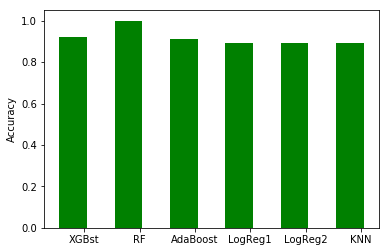

In [34]:
# Plotting the accuracies
import matplotlib.pyplot as plt

x_axis = np.arange(6)
y_axis = [0.92,1,0.91,0.89,0.89,0.89]

plt.bar(x_axis, y_axis, width=0.5, color = 'g')
plt.xticks(x_axis+2/10.,('XGBst','RF',
           'AdaBoost','LogReg1','LogReg2',
            'KNN'))
plt.ylabel('Accuracy')
plt.savefig('Accuracyplot _Approach3_withPCA.png')
plt.show()
